# Controller design

In [ ]:
# ruff: noqa: N802, N803, N806, N815, N816
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import control

import archimedes as arc
from archimedes import struct

from motor import motor_ode, MotorParams, SUPPLY_VOLTAGE, MotorInputs, plant_step, hil_dt

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

In [24]:
with open("_static/data/motor_params.pkl", "rb") as f:
    params = MotorParams(**pickle.load(f))

params

MotorParams(J=array(0.08910903), b=array(0.81924098), L=array(0.00314336), R=array(2.38683236), k_t=array(25.48688943))

## Plant model

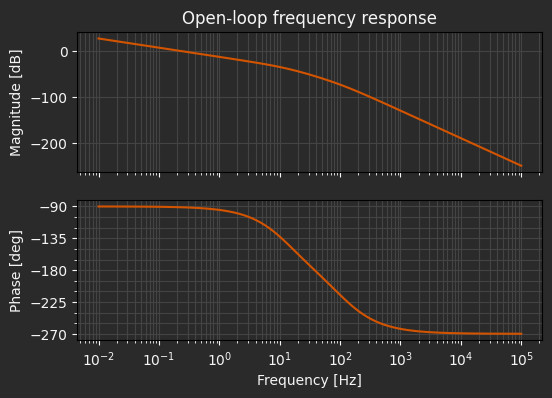

In [51]:
x0 = np.array([0.0, 0.0, 0.0])
u0 = np.array([0.0])

# Extract state-space model using autodiff
A = arc.jac(motor_ode, argnums=1)(0, x0, u0, params)
B = arc.jac(motor_ode, argnums=2)(0, x0, u0, params)
C = np.array([[0.0, 1.0, 0.0]])
D = np.array([[0.0]])

# Transfer function from voltage to position
num, den = signal.ss2tf(A, B, C, D)
G = control.tf(num[0], den, name="plant")

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
control.bode_plot(G, dB=True, Hz=True, omega=np.logspace(-2, 5, 100) * 2*np.pi, ax=ax)
ax[0].set_title("Open-loop frequency response")
plt.show()

## PI controller

In [73]:
kp = 10.0
ki = 3.0

C = control.tf(np.array([kp, ki]), np.array([1, 0]), name="controller")

C

TransferFunction(array([10.,  3.]), array([1, 0]))

Gain margin: 33.54 dB at 37.75 Hz
Phase margin: 76.71 deg at 2.52 Hz


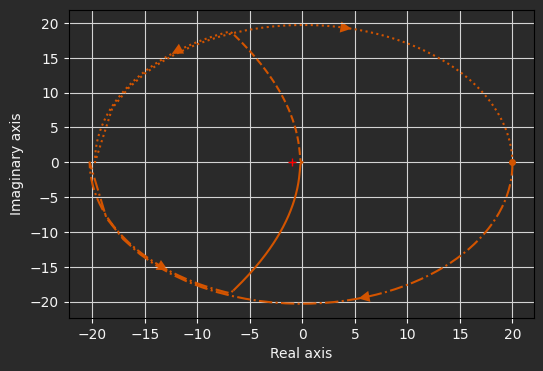

In [74]:
gm, pm, wcg, wcp = control.margin(C * G)
print(f"Gain margin: {20*np.log10(gm):.2f} dB at {wcg/(2*np.pi):.2f} Hz")
print(f"Phase margin: {pm:.2f} deg at {wcp/(2*np.pi):.2f} Hz")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
control.nyquist_plot(C * G, ax=ax)

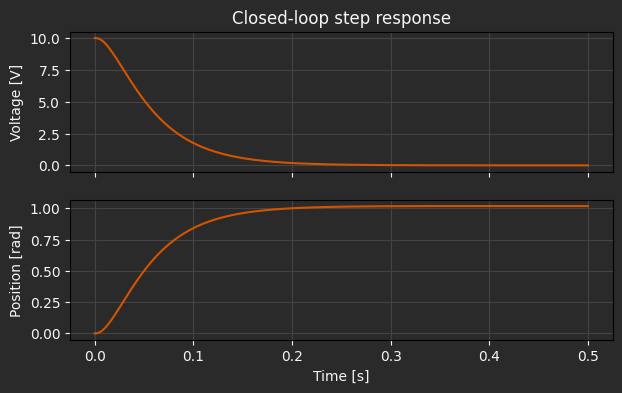

In [75]:
H_ur = C / (1 + G * C)
H_yr = (G * C) / (1 + G * C)

t = np.linspace(0, 0.5, 1000)
yr_resp = control.step_response(H_yr, t)
ur_resp = control.step_response(H_ur, t)

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)

ax[0].set_title("Closed-loop step response")

ax[0].plot(t, ur_resp.outputs)
ax[0].grid()
ax[0].set_ylabel("Voltage [V]")
ax[1].plot(t, yr_resp.outputs)
ax[1].grid()
ax[1].set_ylabel("Position [rad]")

ax[-1].set_xlabel("Time [s]")

plt.show()

## Discretize controller

In [76]:
dt = hil_dt
C_pid = C.sample(dt)  # Position error -> Voltage command
C_pid

TransferFunction(array([10.    , -9.9997]), array([ 1., -1.]), 0.0001)